**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer all questions 

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

Let's first load the needed packages.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [3]:
def gaussian_data_generation(n, mean, cov, noise_std):
   # create data which follows a multivariate Gaussian distribution
   # a white (Gaussian) noise is then added to the data
    
    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"
    
    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data     
   
    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    
def class_int_round(z, n_class):
    # rounding needed to go from real to integer values 
    output = np.round(z).astype(int)
    if isinstance(z, np.ndarray):
        j = z < 0
        output[j] = 0
        k = z > n_class - 1
        output[k] = n_class - 1

    else:
        if output < 0:
            output = 0

        else:
            if output > n_class - 1:
                output = n_class - 1

    return output

The next function is the one you will use to create the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class. 

In [4]:
def generate_scenario(n_classes=3):
    
    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))
        
    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)
        
        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))  

    return X, y

Let's choose a scenario and generate some data

In [21]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=2
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's plot the data

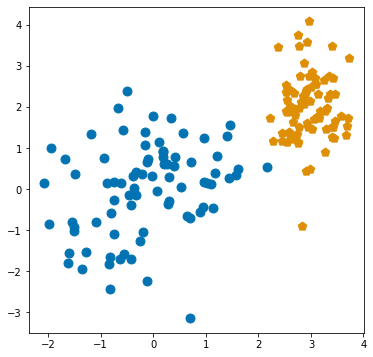

In [22]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.

 **Question**: look at the function 'class_int_round'. Explain what it does.

 **Answer**: The function 'class_int_round' returns the result of classification using the one of regression, by rounding the value of the regressinion result to give the integer which is closest to the number of the class. 
 

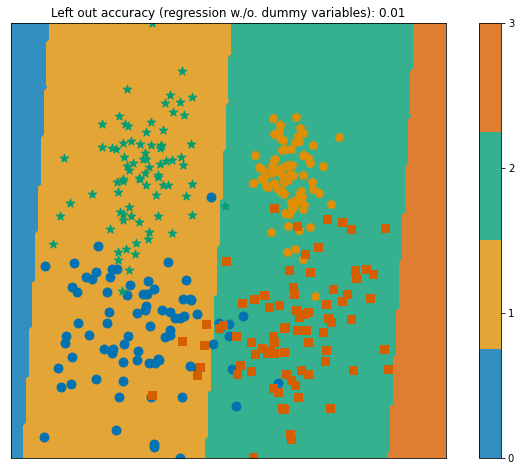

In [11]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################

resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)
#transform the probabilities to corresponding classes ??

# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

**Answer**: In both cases the resulting decision boundaries are lines, but in  the case of naive linear regression on raw observations, they are always parallel to each other which works in simple cases like in the second scenario with 2 classes but it may give a very low accuracy like in the fourth scenario because there is no possible solutions with parralel boundaries. With the OneHotEncoder,there is no constraint on the direction of the boundaries so the separation is more accurate in the 3 scenarios, so overall the OneHotEncoder seems to be a better approach..

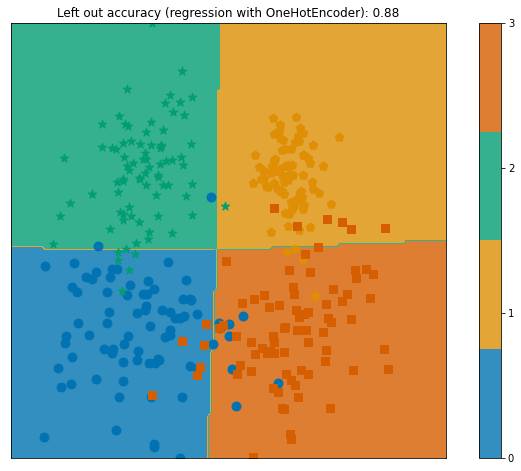

In [13]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150  
enc = OneHotEncoder(categories='auto')
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)
proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

Let's use the other strategies seen this morning.

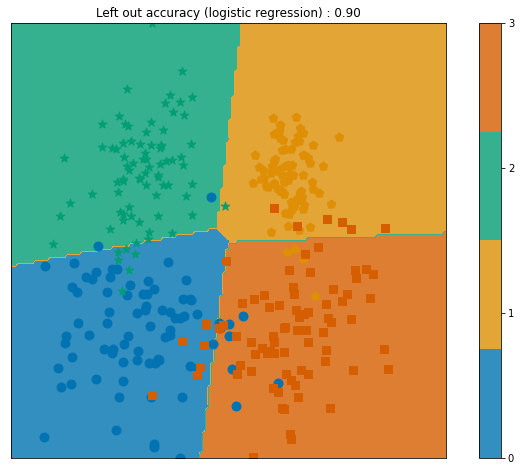

In [14]:
##############################################################################
# Logistic regression
##############################################################################
resolution_param = 150  
clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial', 
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

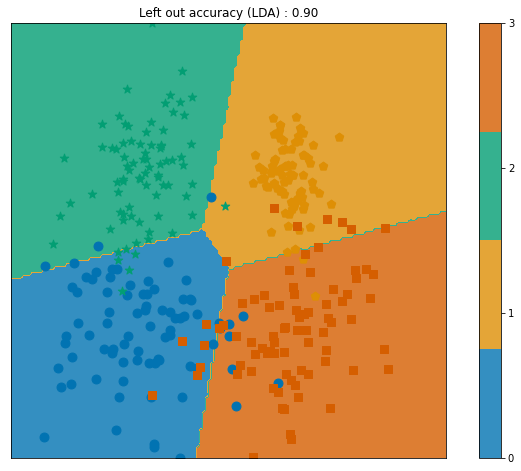

In [15]:
##############################################################################
# LDA
##############################################################################
resolution_param = 150  
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)

title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

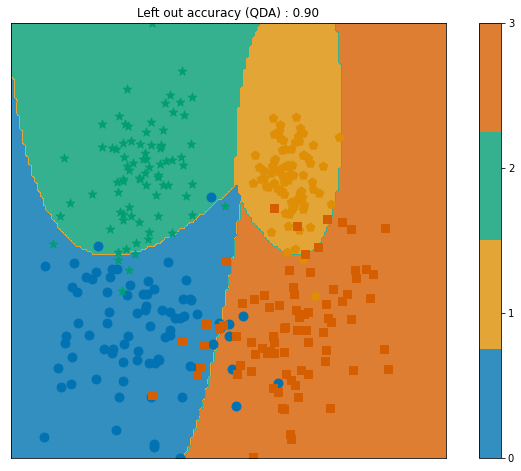

In [16]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150 
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

In [19]:
time_start = time.perf_counter()
resolution_param = 150 
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy QDA', "%.2f" %accuracy_score(y_test, y_QDA_test))

Computational time: 0.00 s ; Test accuracy QDA 0.90


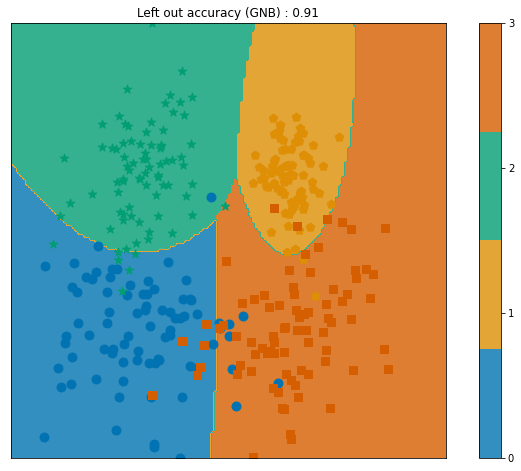

In [17]:
##############################################################################
# Naive Bayes 
##############################################################################
resolution_param = 150  
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)

title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

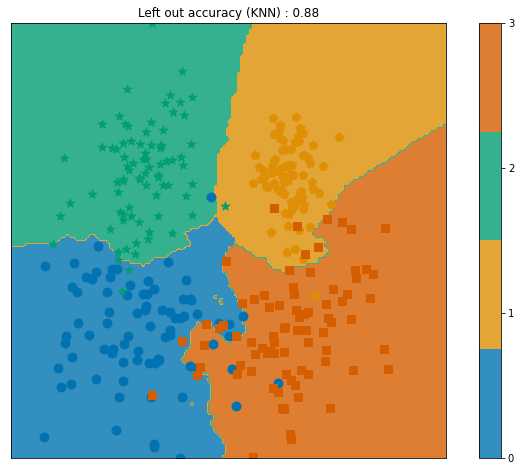

In [18]:
##############################################################################
# KNN
##############################################################################
resolution_param = 150  
clf_KNN = KNeighborsClassifier()
clf_KNN.n_neighbors=5

clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)

title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?
*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.
* (Optional) If you change the number of samples per class (both training and test), do the results vary ?


**Answers**:

* No, boudaries are not all linear. For QDA and GNB they are curvilinear and for KNN they do not have a specific shape. 

* Computational time : 
  * **Logistic regression**:
    * 2 classes : Computational time: 0.0074 s ; Test accuracy logistic regression 0.97

    * 3 classes : Computational time: 0.0298 s ; Test accuracy logistic regression 0.88

    * 4 classes : Computational time: 0.0202 s ; Test accuracy logistic regression 0.90
  * **LDA**:
    * 2 classes : Computational time: 0.0036 s ; Test accuracy LDA 0.93
    * 3 classes : Computational time: 0.0131 s ; Test accuracy LDA 0.78
    * 4 classes : Computational time: 0.0028 s ; Test accuracy LDA 0.90
  * **QDA**:
    * 2 classes : Computational time: 0.0028 s ; Test accuracy QDA 0.97
    * 3 classes : Computational time: 0.0132 s ; Test accuracy QDA 0.87
    * 4 classes : Computational time: 0.0023 s ; Test accuracy QDA 0.90
  * **GNB**: 
    * 2 classes : Computational time: 0.0028 s ; Test accuracy GNB 0.95
    * 3 classes : Computational time: 0.0019 s ; Test accuracy GNB 0.87
    * 4 classes : Computational time: 0.0025 s ; Test accuracy GNB 0.91
  * **KNN**:
    * 2 classes : Computational time: 0.0038 s ; Test accuracy KNN 0.95
    * 3 classes : Computational time: 0.0057 s ; Test accuracy KNN 0.82
    * 4 classes : Computational time: 0.0071 s ; Test accuracy KNN 0.88

  Depending on the number of classes, the method that gives the best accurancy and/or the best computational time is not the same. With 4 classes, QDA is the fastest method but its accuracy is a little bit lower than KNN, LDA and logistic regression. With 3 classes QDA is the fastest method with the best accuracy, followed by GNB.  The logistic regression is the slowest and it gives worse results.Finally with 2 classes, the fastest method is again QDA and the accuricies of all the methods are comparable.

* When we increase the number of samples in the test class from 10% to ~30%, we get better accuray with all the methods and if we increase from ~30% to 90% the acccuray decrease. Indeed, a small test set can lead to unreliable or inaccurate evaluations because of randomness and since it is a limited representation so it may not be representative of the entire dataset, it also increases the risk of overfitting. For large test sets, as the size of a test set increases, it can become more difficult and costly to label the data accurately. This can lead to errors in labeling and potentially inaccurate assessments of the model's performance.
Finally, when we increase the number of samples in the test class from 10% to 90%, the computational timebecomes larger.


In [ ]:
# example using KNN
time_start = time.perf_counter()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy KNN', "%.2f" %accuracy_score(y_test, y_KNN_test))

Computational time: 0.01 s ; Test accuracy KNN 0.85


In [32]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=2
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
#more significant figures after the decimal point are considered 

time_start = time.perf_counter()
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy logistic regression', "%.2f" %accuracy_score(y_test, y_logit_test))

time_start = time.perf_counter()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy LDA', "%.2f" %accuracy_score(y_test, y_LDA_test))

time_start = time.perf_counter()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy QDA', "%.2f" %accuracy_score(y_test, y_QDA_test))

time_start = time.perf_counter()
clf_GNB.fit(X_train, y_train)
y_test_GNB = clf_GNB.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy GNB', "%.2f" %accuracy_score(y_test, y_test_GNB))

time_start = time.perf_counter()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy KNN', "%.2f" %accuracy_score(y_test, y_KNN_test))

Computational time: 0.0073 s ; Test accuracy logistic regression 1.00
Computational time: 0.0030 s ; Test accuracy LDA 1.00
Computational time: 0.0018 s ; Test accuracy QDA 1.00
Computational time: 0.0019 s ; Test accuracy GNB 1.00
Computational time: 0.0045 s ; Test accuracy KNN 1.00


In [64]:
#changing the number of samples per class (both training and test)
######### PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=4
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

time_start = time.perf_counter()
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy logistic regression', "%.2f" %accuracy_score(y_test, y_logit_test))

time_start = time.perf_counter()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy LDA', "%.2f" %accuracy_score(y_test, y_LDA_test))

time_start = time.perf_counter()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy QDA', "%.2f" %accuracy_score(y_test, y_QDA_test))

time_start = time.perf_counter()
clf_GNB.fit(X_train, y_train)
y_test_GNB = clf_GNB.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy GNB', "%.2f" %accuracy_score(y_test, y_test_GNB))

time_start = time.perf_counter()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy KNN', "%.2f" %accuracy_score(y_test, y_KNN_test))

Computational time: 0.0174 s ; Test accuracy logistic regression 0.92
Computational time: 0.0027 s ; Test accuracy LDA 0.92
Computational time: 0.0020 s ; Test accuracy QDA 0.90
Computational time: 0.0027 s ; Test accuracy GNB 0.91
Computational time: 0.0064 s ; Test accuracy KNN 0.88
